# Recreation of accepted solution from Challenge on LINE 1003.02

In [1]:
import torch
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import random

import magnav



In [2]:
print(f'PyTorch version : {torch.__version__}, Version used for dev : 1.9.0+cu102')

PyTorch version : 1.9.0+cu102, Version used for dev : 1.9.0+cu102


In [3]:
torch.manual_seed(27) # For reproducibility
random.seed(27)
np.random.seed(27)
torch.cuda.manual_seed(27)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# 0 - Load Solution Dataset

In [4]:
# Create a widget to select the flight to load

w_flight = widgets.ToggleButtons(
    options=[('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5)],
    value=3,
    description='Load flight')
display(w_flight)

ToggleButtons(description='Load flight', index=1, options=(('1002', 2), ('1003', 3), ('1004', 4), ('1005', 5))…

In [5]:
df = pd.read_hdf('../data/interim/Sol_dataset.h5', key=f'Flt100{w_flight.value}')

In [6]:
df.head()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,
49820.0,52836.179,40991.107,56629.409,-24121.629,-22136.973,10486.244,-770.948052,53000.806,-1837.427211,-132.727664,26.210,1003.01,-183.066
49820.1,52834.254,40995.387,56629.059,-24107.552,-22123.009,10491.522,-761.257336,53011.817,-1837.994231,-131.784263,26.169,1003.01,-183.522
49820.2,52832.980,41000.448,56627.953,-24095.028,-22109.401,10497.816,-757.416996,53016.958,-1838.356508,-129.755380,26.022,1003.01,-183.957
49820.3,52832.305,41006.539,56626.660,-24084.577,-22097.326,10505.743,-759.437211,53016.190,-1838.998602,-127.464817,25.839,1003.01,-184.368
49820.4,52832.223,41013.213,56625.663,-24076.470,-22088.167,10515.313,-765.931913,53010.724,-1839.819941,-125.954372,25.731,1003.01,-184.759


In [7]:
df_filt = df[['TL_comp_mag3_sq','TL_comp_mag4_sq','TL_comp_mag5_sq']].loc[df.LINE==1003.02].copy()
df_filt_2 = df[['TL_comp_mag3_sq','TL_comp_mag4_sq','TL_comp_mag5_sq']].loc[df.LINE==1003.08].copy()

# 1 - Preprocessing

## 1.1 - Low pass filter

This filter comes from Matlab lowpass filter (This are the coefficients extracted from Matlab)

In [8]:
num = [0.00013485,0.00014468,7.8213e-05,-0.00010382,-0.00043744,-0.00094761,-0.0016395,-0.0024902,-0.0034418,-0.0043974,
        -0.005221,-0.0057423,-0.0057668,-0.0050899,-0.003516,-0.00087932,0.0029351,0.007972,0.014191,0.021457,0.029541,0.03813,
        0.046838,0.055236,0.062881,0.069347,0.074263,0.077335,0.078381,0.077335,0.074263,0.069347,0.062881,0.055236,0.046838,
        0.03813,0.029541,0.021457,0.014191,0.007972,0.0029351,-0.00087932,-0.003516,-0.0050899,-0.0057668,-0.0057423,-0.005221,
        -0.0043974,-0.0034418,-0.0024902,-0.0016395,-0.00094761,-0.00043744,-0.00010382,7.8213e-05,0.00014468,0.00013485]
den = 1

sos = signal.tf2sos(num,den)

In [9]:
df_filt['FLUXB_TOT']  = signal.sosfiltfilt(sos,df['FLUXB_TOT'].loc[df.LINE==1003.02])
df_filt['FLUXB_X']    = signal.sosfiltfilt(sos,df['FLUXB_X'].loc[df.LINE==1003.02])
df_filt['FLUXC_TOT']  = signal.sosfiltfilt(sos,df['FLUXC_TOT'].loc[df.LINE==1003.02])
df_filt['FLUXC_Y']    = signal.sosfiltfilt(sos,df['FLUXC_Y'].loc[df.LINE==1003.02])
df_filt['FLUXD_Y']    = signal.sosfiltfilt(sos,df['FLUXD_Y'].loc[df.LINE==1003.02])
df_filt['FLUXD_Z']    = signal.sosfiltfilt(sos,df['FLUXD_Z'].loc[df.LINE==1003.02])
df_filt['UNCOMPMAG3'] = signal.sosfiltfilt(sos,df['UNCOMPMAG3'].loc[df.LINE==1003.02])
df_filt['V_CABT']     = signal.sosfiltfilt(sos,df['V_CABT'].loc[df.LINE==1003.02])

df_filt_2['FLUXB_TOT']  = signal.sosfiltfilt(sos,df['FLUXB_TOT'].loc[df.LINE==1003.08])
df_filt_2['FLUXB_X']    = signal.sosfiltfilt(sos,df['FLUXB_X'].loc[df.LINE==1003.08])
df_filt_2['FLUXC_TOT']  = signal.sosfiltfilt(sos,df['FLUXC_TOT'].loc[df.LINE==1003.08])
df_filt_2['FLUXC_Y']    = signal.sosfiltfilt(sos,df['FLUXC_Y'].loc[df.LINE==1003.08])
df_filt_2['FLUXD_Y']    = signal.sosfiltfilt(sos,df['FLUXD_Y'].loc[df.LINE==1003.08])
df_filt_2['FLUXD_Z']    = signal.sosfiltfilt(sos,df['FLUXD_Z'].loc[df.LINE==1003.08])
df_filt_2['UNCOMPMAG3'] = signal.sosfiltfilt(sos,df['UNCOMPMAG3'].loc[df.LINE==1003.08])
df_filt_2['V_CABT']     = signal.sosfiltfilt(sos,df['V_CABT'].loc[df.LINE==1003.08])

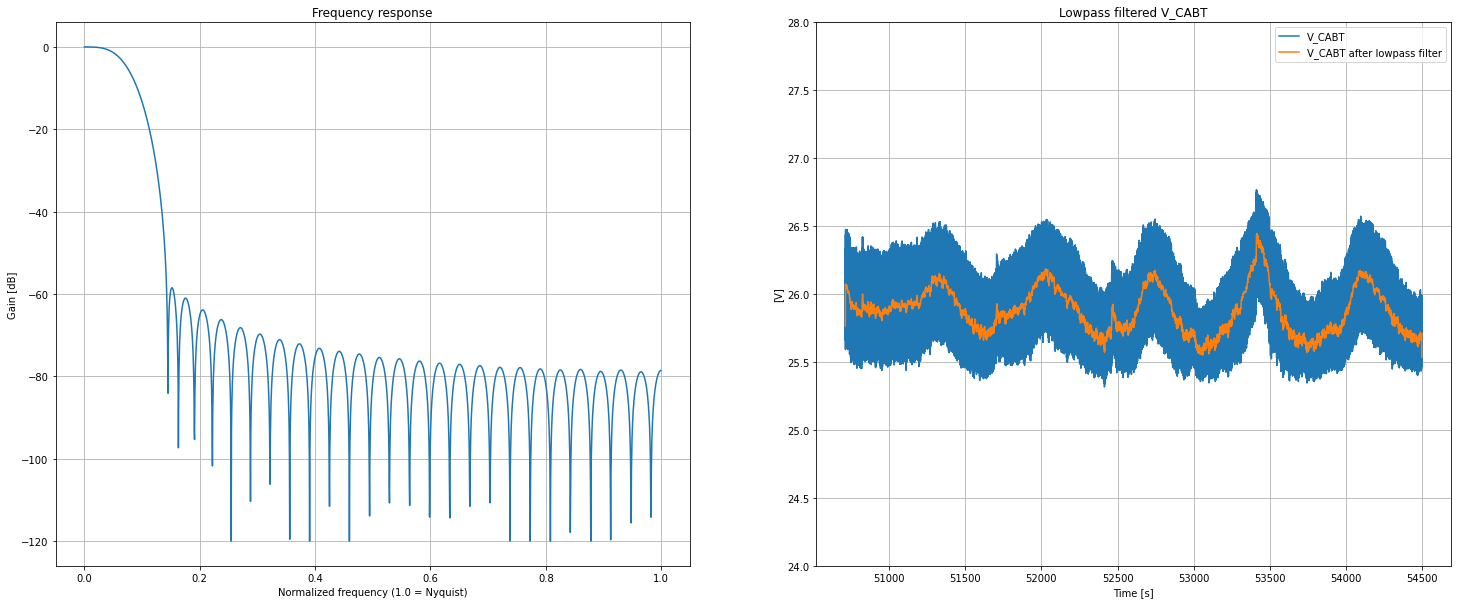

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

w, h = signal.sosfreqz(sos, worN=2000)
db = 20*np.log10(np.maximum(np.abs(h),1e-6))

ax1.plot(w/np.pi,db)

ax1.grid()
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')


window = 5000 # Number of seconds to plot 
ax2.plot(df['V_CABT'].loc[df.LINE==1003.02],label='V_CABT')
ax2.plot(df_filt['V_CABT'],label='V_CABT after lowpass filter')

ax2.grid()
ax2.legend()
ax2.set_ylim([24,28])
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[V]')
ax2.set_title('Lowpass filtered V_CABT')
plt.show()

## 1.2 - Standardization

<font size="5">
$z = \frac{x-\mu}{\sigma}$
</font>

Transformation to a standard normal distribution

In [11]:
df_filt.head()

,TL_comp_mag3_sq,TL_comp_mag4_sq,TL_comp_mag5_sq,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,UNCOMPMAG3,V_CABT
Time [s],,,,,,,,,,,
50713.0,-950.772376,-2071.372550,-61.063570,52809.995683,45836.756733,57309.609235,-20373.111110,-17985.300142,16380.959101,53524.214262,25.764129
50713.1,-948.311424,-2070.150151,-61.193859,52810.549017,45821.237035,57309.093511,-20398.057302,-18011.092309,16355.481028,53522.168433,25.799961
50713.2,-945.399256,-2068.744456,-60.430321,52811.056880,45805.304785,57308.501120,-20422.486899,-18036.394727,16329.119145,53520.056058,25.835170
50713.3,-942.605337,-2067.344488,-59.631363,52811.476194,45788.571859,57307.759115,-20445.895748,-18060.728540,16301.037242,53517.815189,25.869157
50713.4,-940.197260,-2066.215693,-58.782155,52811.768560,45770.697930,57306.801853,-20467.803994,-18083.636157,16270.492298,53515.392854,25.901375


In [12]:
scaler = StandardScaler()
df_filt[df_filt.columns] = scaler.fit_transform(df_filt[df_filt.columns])
df_filt_2[df_filt_2.columns] = scaler.fit_transform(df_filt_2[df_filt_2.columns])

In [13]:
df_filt.describe()

,TL_comp_mag3_sq,TL_comp_mag4_sq,TL_comp_mag5_sq,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,UNCOMPMAG3,V_CABT
count,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04,3.784100e+04
mean,1.051515e-17,-5.347707e-16,4.206061e-17,-5.648140e-15,-3.244676e-16,1.646373e-15,7.210391e-17,-4.806927e-17,9.613855e-17,2.890165e-15,-8.556331e-15
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00
min,-2.027842e+00,-2.066633e+00,-2.079654e+00,-1.934920e+00,-2.841863e+00,-2.595545e+00,-1.377900e+00,-1.429092e+00,-2.364873e+00,-1.720460e+00,-2.059999e+00
25%,-7.522084e-01,-6.811861e-01,-5.688710e-01,-9.466533e-01,-1.050642e+00,-9.421943e-01,-1.152883e+00,-1.155758e+00,-9.880042e-01,-7.611037e-01,-8.519593e-01
50%,-7.759354e-02,-5.878911e-02,-1.448606e-01,-6.846005e-03,3.580638e-01,5.886522e-02,6.102619e-01,6.057908e-01,1.763257e-01,-1.900931e-01,-3.113699e-02
75%,5.465136e-01,4.296296e-01,4.445039e-01,7.349789e-01,7.261658e-01,7.212697e-01,8.554880e-01,8.443283e-01,6.115070e-01,3.825222e-01,7.128256e-01
max,5.155873e+00,4.851345e+00,4.489895e+00,3.755269e+00,2.038493e+00,2.780636e+00,1.412930e+00,1.442044e+00,3.072854e+00,3.702521e+00,3.392607e+00


## 1.3 - Time Frame

Input : $[t_{-2}, t_{-1}, t_{0}, t_{+1}, t_{+2}]$

Model generate an output for $t_{0}$

In [14]:
t_0 = df_filt.index[2]
t_end = df_filt.index[-3]
print(f'With the new time frame, Start time = {t_0}s and End time = {t_end}s.')

t_0_2 = df_filt_2.index[2]
t_end_2 = df_filt_2.index[-3]
print(f'With the new time frame, Start time = {t_0_2}s and End time = {t_end_2}s.')

With the new time frame, Start time = 50713.2s and End time = 54496.8s.
With the new time frame, Start time = 60243.2s and End time = 64585.8s.


In [15]:
y = df[['IGRFMAG1']].loc[df.LINE==1003.02].copy()
y = y.drop(index=[y.index[0],y.index[1],y.index[-2],y.index[-1]])

y_2 = df[['IGRFMAG1']].loc[df.LINE==1003.08].copy()
y_2 = y_2.drop(index=[y_2.index[0],y_2.index[1],y_2.index[-2],y_2.index[-1]])

y[y.columns] = scaler.fit_transform(y[y.columns])

In [16]:
idx = df_filt.drop(index=[df_filt.index[0],df_filt.index[1],df_filt.index[-1],df_filt.index[-2]]).index
idx_2 = df_filt_2.drop(index=[df_filt_2.index[0],df_filt_2.index[1],df_filt_2.index[-1],df_filt_2.index[-2]]).index

X = pd.concat([df_filt.drop(index=[df_filt.index[-1],df_filt.index[-2],df_filt.index[-3],df_filt.index[-4]]).set_index(idx),
               df_filt.drop(index=[df_filt.index[0],df_filt.index[-1],df_filt.index[-2],df_filt.index[-3]]).set_index(idx),
               df_filt.drop(index=[df_filt.index[0],df_filt.index[1],df_filt.index[-1],df_filt.index[-2]]),
               df_filt.drop(index=[df_filt.index[0],df_filt.index[1],df_filt.index[2],df_filt.index[-1]]).set_index(idx),
               df_filt.drop(index=[df_filt.index[0],df_filt.index[1],df_filt.index[2],df_filt.index[3]]).set_index(idx)
               ],axis=1)

X_2 = pd.concat([df_filt_2.drop(index=[df_filt_2.index[-1],df_filt_2.index[-2],df_filt_2.index[-3],df_filt_2.index[-4]]).set_index(idx_2),
               df_filt_2.drop(index=[df_filt_2.index[0],df_filt_2.index[-1],df_filt_2.index[-2],df_filt_2.index[-3]]).set_index(idx_2),
               df_filt_2.drop(index=[df_filt_2.index[0],df_filt_2.index[1],df_filt_2.index[-1],df_filt_2.index[-2]]),
               df_filt_2.drop(index=[df_filt_2.index[0],df_filt_2.index[1],df_filt_2.index[2],df_filt_2.index[-1]]).set_index(idx_2),
               df_filt_2.drop(index=[df_filt_2.index[0],df_filt_2.index[1],df_filt_2.index[2],df_filt_2.index[3]]).set_index(idx_2)
               ],axis=1)

X

,TL_comp_mag3_sq,TL_comp_mag4_sq,TL_comp_mag5_sq,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,UNCOMPMAG3,...,TL_comp_mag4_sq,TL_comp_mag5_sq,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,UNCOMPMAG3,V_CABT
Time [s],,,,,,,,,,,,,,,,,,,,,
50713.2,0.280821,-0.119661,-0.566285,1.126443,1.180368,1.119065,-1.051534,-1.033792,1.087971,0.933226,...,-0.101833,-0.557236,1.129080,1.173395,1.116833,-1.057693,-1.040237,1.079112,0.924884,0.140021
50713.3,0.286862,-0.115435,-0.566802,1.127266,1.178730,1.118655,-1.053157,-1.035482,1.085927,0.931291,...,-0.100125,-0.553600,1.129279,1.171359,1.115857,-1.058992,-1.041617,1.076417,0.922384,0.319574
50713.4,0.294010,-0.110575,-0.563773,1.128021,1.177048,1.118184,-1.054746,-1.037141,1.083814,0.929294,...,-0.099638,-0.549623,1.129208,1.169154,1.114633,-1.060138,-1.042850,1.073440,0.919653,0.483348
50713.5,0.300869,-0.105735,-0.560604,1.128645,1.175282,1.117594,-1.056268,-1.038736,1.081562,0.927175,...,-0.099163,-0.545172,1.128847,1.166773,1.113141,-1.061108,-1.043914,1.070162,0.916684,0.629621
50713.6,0.306780,-0.101833,-0.557236,1.129080,1.173395,1.116833,-1.057693,-1.040237,1.079112,0.924884,...,-0.098662,-0.540113,1.128192,1.164217,1.111374,-1.061884,-1.044789,1.066582,0.913494,0.757310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54496.4,-1.216322,-1.000229,-0.657570,-1.131733,-0.662192,-0.708714,1.076508,1.074322,-0.539014,-0.756410,...,-0.979695,-0.653581,-1.154027,-0.689066,-0.738551,1.070943,1.067966,-0.566730,-0.783059,-1.514206
54496.5,-1.215909,-0.995220,-0.657120,-1.136092,-0.667193,-0.714382,1.075415,1.073077,-0.544129,-0.761691,...,-0.978173,-0.652029,-1.161298,-0.698173,-0.748512,1.069131,1.065893,-0.576190,-0.791630,-1.639831
54496.6,-1.214961,-0.989125,-0.656272,-1.141317,-0.673422,-0.721327,1.074110,1.071588,-0.550538,-0.767962,...,-0.979768,-0.650767,-1.169013,-0.707896,-0.759123,1.067208,1.063692,-0.586308,-0.800691,-1.774600


Each 11 columns is shifted of 0.1s to get the new time frame with the start index time shifted of 0.2s and index end time shifted of -0.2s.

## 1.4 - Train and Validation set

Train = 4/5, Validation = 1/5

In [17]:
batch = 64

GPU Check

In [18]:
device = magnav.get_device()
device = 'cpu'

Currently using cuda


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=1/5,shuffle=False)
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2,y_2,test_size=1/5,shuffle=False)

In [20]:
print(f'X_train : {np.shape(X_train)} {type(X_train)}\nX_val   : {np.shape(X_val)}  {type(X_val)}\n\ny_train : {np.shape(y_train)}  {type(y_train)}\ny_val   : {np.shape(y_val)}   {type(y_val)}')

X_train : (30269, 55) <class 'pandas.core.frame.DataFrame'>
X_val   : (7568, 55)  <class 'pandas.core.frame.DataFrame'>

y_train : (30269, 1)  <class 'pandas.core.frame.DataFrame'>
y_val   : (7568, 1)   <class 'pandas.core.frame.DataFrame'>


In [21]:
X_train = torch.from_numpy(X_train.to_numpy()).float().to(device)
y_train = torch.from_numpy(y_train.to_numpy()).float().to(device)

X_val = torch.from_numpy(X_val.to_numpy()).float().to(device)
y_val = torch.from_numpy(y_val.to_numpy()).float().to(device)

X_train_2 = torch.from_numpy(X_train_2.to_numpy()).float().to(device)
y_train_2 = torch.from_numpy(y_train_2.to_numpy()).float().to(device)

X_val_2 = torch.from_numpy(X_val_2.to_numpy()).float().to(device)
y_val_2 = torch.from_numpy(y_val_2.to_numpy()).float().to(device)

In [22]:
print(f'X_train : {np.shape(X_train)} {X_train.dtype}\nX_val   : {np.shape(X_val)}  {X_val.dtype}\n\ny_train : {np.shape(y_train)}  {y_train.dtype}\ny_val   : {np.shape(y_val)}   {y_val.dtype}')

X_train : torch.Size([30269, 55]) torch.float32
X_val   : torch.Size([7568, 55])  torch.float32

y_train : torch.Size([30269, 1])  torch.float32
y_val   : torch.Size([7568, 1])   torch.float32


In [23]:
train_tensor = torch.utils.data.TensorDataset(X_train,y_train)
train_loader = torch.utils.data.DataLoader(dataset=train_tensor,batch_size=batch,shuffle=False)

val_tensor   = torch.utils.data.TensorDataset(X_val,y_val)
val_loader   = torch.utils.data.DataLoader(dataset=val_tensor,batch_size=batch,shuffle=False)

train_tensor_2 = torch.utils.data.TensorDataset(X_train_2,y_train_2)
train_loader_2 = torch.utils.data.DataLoader(dataset=train_tensor_2,batch_size=batch,shuffle=False)

val_tensor_2   = torch.utils.data.TensorDataset(X_val_2,y_val_2)
val_loader_2   = torch.utils.data.DataLoader(dataset=val_tensor_2,batch_size=batch,shuffle=False)

# 2 - MLP

## 2.1 - Model from scratch

### 2.2.1 - Architecture

In [24]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [25]:
class Chall_MLP(torch.nn.Module):
    
    def __init__(self):
        super(Chall_MLP, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(55,50),
            torch.nn.Tanh(),
            torch.nn.Linear(50,30),
            torch.nn.Tanh(),
            torch.nn.Linear(30,10),
            torch.nn.Tanh(),
            torch.nn.Linear(10,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

In [26]:
model = Chall_MLP().to(device)
print(model)

Chall_MLP(
  (architecture): Sequential(
    (0): Linear(in_features=55, out_features=50, bias=True)
    (1): Tanh()
    (2): Linear(in_features=50, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=10, bias=True)
    (5): Tanh()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)


### 2.2.2 - Loss Function

This class ensure that during a backward pass, when you multiply 0 by $\infty$ (derivative of $\sqrt{0}$), the returned tensor will be 0 and not Nan

In [27]:
class RMSELoss(torch.nn.Module):
    
    def __init__(self):
        super(RMSELoss,self).__init__()
        
    def forward(self,yhat,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(yhat,y)+1e-6)
        return loss 

In [28]:
criterion = RMSELoss()

### 2.2.3 - Optimizer

In [29]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [30]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9,patience=5,min_lr=4e-6)

### 2.2.4 - Training loop

In [31]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Chall_MLP_{timestamp}')

EPOCHS = 1000

pbar = tqdm_notebook(total=EPOCHS,unit=" epoch",desc='Training')

for epoch in range(EPOCHS):

    train_running_loss = 0.

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)

    # Enumerate allow to track batch index and intra-epoch reporting 
    for i, (inputs, labels) in enumerate(train_loader):

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make prediction for this batch
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(predictions, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.detach().item() * inputs.size(0)
        

    avg_loss = train_running_loss/ len(train_loader.dataset)
    writer.add_scalar('training_loss',avg_loss,epoch)
    
    # Desactivate layers such as dropout or batch-normalization
    model.train(False)

    val_running_loss = 0.0
    
    
    with torch.set_grad_enabled(False):
        for i, (vinputs, vlabels) in enumerate(val_loader):

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            val_running_loss += vloss.detach().item()* vinputs.size(0)

    avg_vloss = val_running_loss/len(val_loader.dataset)
    
    scheduler.step(avg_vloss)
    
    writer.add_scalar('validation_loss',avg_vloss,epoch)
    
    pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
    pbar.update()

Training:   0%|          | 0/1000 [00:00<?, ? epoch/s]

In [34]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9,patience=5,min_lr=4e-6)

In [32]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Chall_MLP_{timestamp}')

EPOCHS = 400

pbar = tqdm_notebook(total=EPOCHS,unit=" epoch",desc='Training')

for epoch in range(EPOCHS):

    train_running_loss = 0.

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)

    # Enumerate allow to track batch index and intra-epoch reporting 
    for i, (inputs, labels) in enumerate(train_loader_2):

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make prediction for this batch
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(predictions, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.detach().item() * inputs.size(0)
        

    avg_loss = train_running_loss/ len(train_loader.dataset)
    writer.add_scalar('training_loss',avg_loss,epoch)
    
    # Desactivate layers such as dropout or batch-normalization
    model.train(False)

    val_running_loss = 0.0
    
    
    with torch.set_grad_enabled(False):
        for i, (vinputs, vlabels) in enumerate(val_loader_2):

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            val_running_loss += vloss.detach().item()* vinputs.size(0)

    avg_vloss = val_running_loss/len(val_loader.dataset)
    
    scheduler.step(avg_vloss)
    
    writer.add_scalar('validation_loss',avg_vloss,epoch)
    
    pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
    pbar.update()

Training:   0%|          | 0/400 [00:00<?, ? epoch/s]

# 3 - Predictions

9.541996


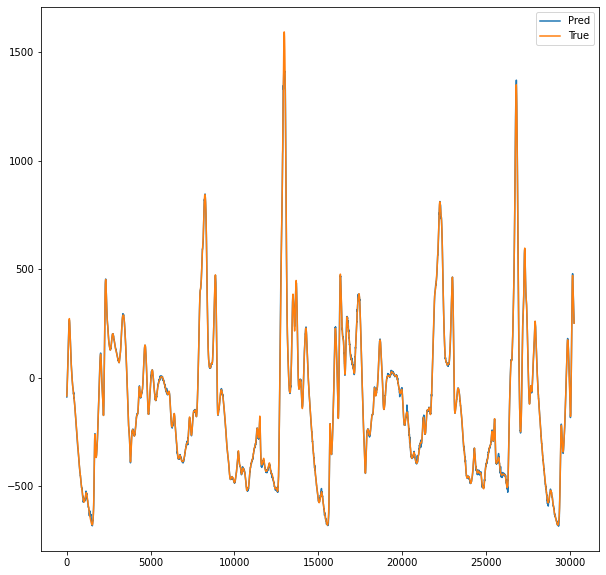

In [37]:
with torch.no_grad():
    pred = model(X_train)
    
    fig, ax = plt.subplots(figsize=[10,10])
    plt.plot(scaler.inverse_transform(pred.cpu().detach().numpy()),label='Pred')
    plt.plot(scaler.inverse_transform(y_train.cpu().detach().numpy()),label='True')
    plt.legend()
    print(magnav.rmse(scaler.inverse_transform(pred.cpu().detach().numpy()),scaler.inverse_transform(y_train.cpu().detach().numpy())))